## Analysis of Simulated mutational count data
In order to compare a linear Autoencoders' and classis NMFs ability to recreate signatures, I simulated a mutational profile dataset from 5 random COSMIC signatures, using a zero-inflated Poisson model.
No cross-validation has been implemented yet, so we assume the true rank (4) in both models.
Firstly, we load the relevant packages.

In [49]:
# -*- coding: utf-8 -*-

import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import NMF

from random import sample

import copy
from functions import plotsigs, cosine_perm, simulate_counts
from NMFAE_init import NMFAE, train_NMFAE

# Load data
The data was simulated in R, and stored on the Q-drive. We simulated 600 patients.

In [50]:
n_sigs = 4
mut_matrix, signatures, _ = simulate_counts(n_sigs, 600)
context = mut_matrix.index
mutation = [s[2:5] for s in context]
mut_matrix = mut_matrix.transpose()

# Signature extraction using NMF
Firstly, we extract signatures using classic NMF from the sklearn model. 
The results 

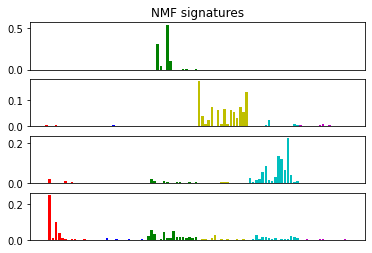

In [51]:
nmf_model = NMF(n_components=n_sigs, init = 'random', max_iter = 500)
exposures = nmf_model.fit_transform(mut_matrix)
signaturesNMF = nmf_model.components_.transpose()

plotsigs(context, mutation, signaturesNMF, n_sigs, "NMF signatures")  

# Signature extraction using linear AE
Secondly, we extracy signatures using a one-hidden-layer autoencoder with no activation functions. The model definition and and training method is loaded from the Python script NMFAE_init.py.

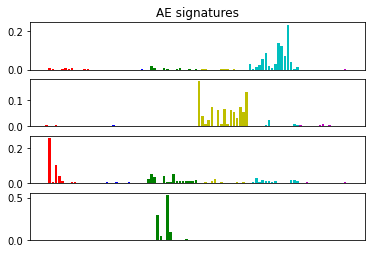

In [52]:
model = NMFAE(dim1 = n_sigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                              lr = 1e-3)#,
                             #weight_decay = 1e-8)
                             
train_NMFAE(epochs = 500, 
               model = model, 
               x_train = mut_matrix, 
               loss_function = loss_function, 
               optimizer = optimizer)

W = model.dec1.weight.data    
W_array = W.numpy()

plotsigs(context, mutation, W_array, n_sigs, "AE signatures")  

# Comparison to true signatures
The data is genereated form signatures SBS28, SBS47, SBS52 and SBS59.
The NMF and AE signatures are ordered according to the best match with the true signature set.
Lastly I plot a heatmap of the cosine similarity between the true signatures and the NMF and AE signatures respectively.

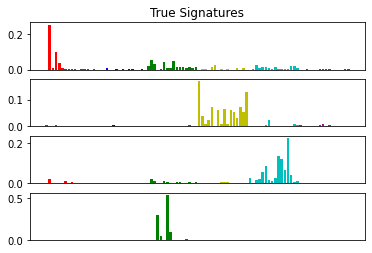

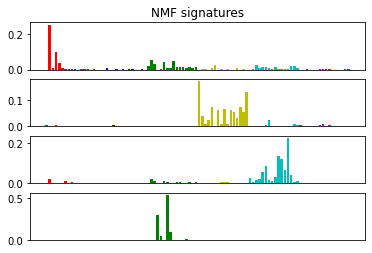

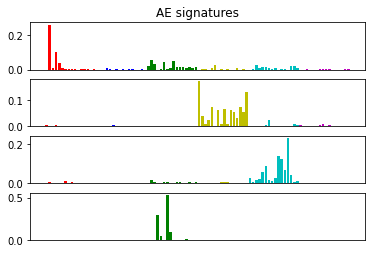

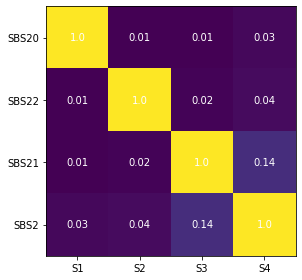

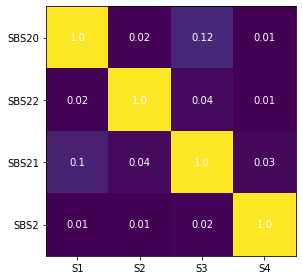

In [53]:
sigs = signatures
sig_names = sigs.columns
plotsigs(context, mutation, sigs.to_numpy(), n_sigs, "True Signatures") 

perm_NMF = cosine_perm(sigs.to_numpy().transpose(), signaturesNMF.transpose())
perm_AE = cosine_perm(sigs.to_numpy().transpose(),W_array.transpose())

#rearrange signature array with permutation idx
NMF_perm = perm_NMF[1]
NMF_idx = np.empty_like(NMF_perm)
NMF_idx[NMF_perm] = np.arange(len(NMF_perm))
NMF_plot = signaturesNMF[:,NMF_idx]

plotsigs(context, mutation, NMF_plot, n_sigs, "NMF signatures")  

#rearrange signature array with permutation idx
AE_perm = perm_AE[1]
AE_idx = np.empty_like(AE_perm)
AE_idx[AE_perm] = np.arange(len(AE_perm))
AE_plot = W_array[:,AE_idx]

plotsigs(context, mutation, AE_plot, n_sigs, "AE signatures")  

#create heatmaps
names = ['S' + str(i + 1) for i in range(n_sigs)]
for res in [np.round(perm_NMF[0],2), np.round(perm_AE[0],2)]:
    fig, ax = plt.subplots()
    im = ax.imshow(res)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(names)
    ax.set_yticks(np.arange(len(sig_names)))
    ax.set_yticklabels(sig_names)

    for i in range(len(names)):
        for j in range(len(names)):
            text = ax.text(j, i, res[i, j],
                        ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()